In [1]:
# !pip install -r requirements.txt

In [2]:
import ABC,Models
import SummaryStatisticSelection as SSS

import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from sys import maxsize

In [3]:
# Size plots
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

In [4]:
# This is only included so that my comments about results hold.
seed=23032020

This notebook demonstrates some of the summary statistic selection methods which I have implemented in `SummaryStatisticSelection.py`. In practice it is recommened to either run each algorithm multiple times or to significantly increase the number of simulations supplied to each one.

 * [Set-Up](#Set-Up)
 * [Minimum Entropy](#Minimum-Entropy)
 * [Two-Step Minimum Entropy](#Two-Step-Minimum-Entropy)
 * [Approximately Sufficient Subset](#Approximately-Sufficient-Subset)
 * [Semi-Automatic ABC](#Semi-Automatic-ABC)

# Set-Up
### Model
I will demonstrate each ABC method on an SIR model for a population of 100,000 with 100 initial infectees and parameters $\beta=1$ and $\gamma=0.5$. This is the model used in my report and defined below.

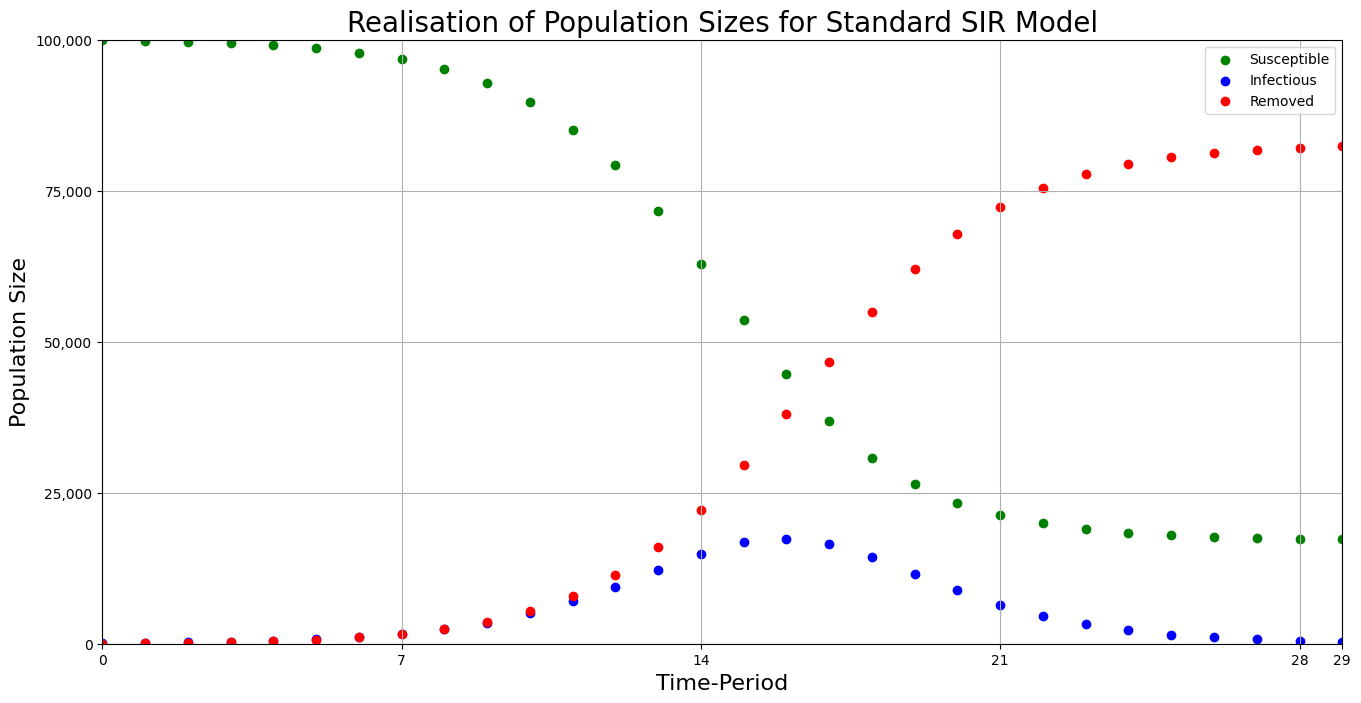

In [5]:
# Model
population_size=100000
initially_infected=100
beta=1
gamma=.5

sm=Models.SIRModel(
    params=[population_size,initially_infected,beta,gamma],
    n_obs=30,
    x_obs=[[x] for x in range(30)]
    )
sm.plot_obs()

### Priors
$$ \pi_0(\beta)\sim\text{Uniform}[0,2.5] $$
$$ \pi_0(\gamma)\sim\text{Uniform}[0,0.8] $$

Due to implementation choices, priors need to be defined for the population size and initial number of infectees, but these are assumed known so are passed distributions which produce constant values.

In [6]:
# Priors
beta_prior=stats.uniform(0,2.5)
gamma_prior=stats.uniform(0,0.8)

sm_priors=[stats.uniform(100000,0),stats.uniform(100,0),beta_prior,gamma_prior]

### Suggests Summary Statistics
A selection of possible summary statistics for methods to choose from. For demonstration purposes, this is a truncated version of the list I used I reference in my report.

In [7]:
final_infectious_ss=(lambda ys:[np.log(ys[-1][1])])
final_removed_ss=(lambda ys:[np.log(ys[-1][2])])

net_weekly_infections_ss=(lambda ys:[np.log(abs(ys[i][1]-ys[i-7][1])) for i in range(7,len(ys)-1,7)]) # weekly change in infections (dim=3)
net_weekly_removed_ss=(lambda ys:[np.log(abs(ys[i][2]-ys[i-7][2])) for i in range(7,len(ys)-1,7)])

net_daily_infections_ss=(lambda ys:[np.log(max(abs(ys[i+1][1]-ys[i][1]),1)) for i in range(0,len(ys)-1)]) # daily change in infections (dim=29)
net_daily_removed_ss=(lambda ys:[np.log(max(abs(ys[i+1][2]-ys[i][2]),np.e)) for i in range(0,len(ys)-1)])

mean_infectious_ss=(lambda ys:[np.log(np.mean([y[1] for y in ys]))])
mean_removed_ss=(lambda ys:[np.log(np.mean([y[2] for y in ys]))])

possible_summary_stats=[final_infectious_ss,final_removed_ss, #0,1
               net_weekly_infections_ss,net_weekly_removed_ss, #2,3
               net_daily_infections_ss,net_daily_removed_ss, #4,5
               mean_infectious_ss,mean_removed_ss, #6,7
               ]

# Minimum Entropy
Minimum Entropy algorithm considering all subsets of size 1 to 3 from `possible_summary_stats`. Generates 10,000 simulations for each subset and keeps the best 100 to estimate entropy with.

In [8]:
%%time
np.random.seed(seed) # Fix random seed

recommended_me,accepted_theta_me=SSS.minimum_entropy(
    summary_stats=possible_summary_stats,
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors,
    min_subset_size=1,
    max_subset_size=3,
    n_samples=10000,
    n_accept=100,
    k=4,
    printing=False
)

Wall time: 7min 46s


In [9]:
recommended_me

(3, 6, 7)

# Two-Step Minimum Entropy
Two-Step Minimum Entropy algorithm considering all subsets of size 1 to 3 from `possible_summary_stats`. Generates 10,000 simulations for each subset and keeps the best 100 to estimate entropy with.

In [10]:
%%time
np.random.seed(seed) # Fix random seed

recommended_2_me,accepted_theta_2_me=SSS.two_step_minimum_entropy(
    summary_stats=possible_summary_stats,
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors,
    min_subset_size=1,
    max_subset_size=3,
    n_samples=10000,
    n_accept=100,
    n_keep=100,
    k=4,
    printing=False
)

Wall time: 13min 43s


In [11]:
recommended_2_me

(3, 6, 7)

# Approximately Sufficient Subset

In [12]:
%%time
np.random.seed(seed) # Fix random seed

recommended_jm=SSS.joyce_marjoram(
    summary_stats=possible_summary_stats,
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors,
    param_bounds=[(100000,100000),(100,100),(0,2.5),(0,0.8)],
    distance_measure=ABC.log_l2_norm,
    KERNEL=ABC.gaussian_kernel,
    BANDWIDTH=1,
    n_samples=10000,
    n_bins=10,
    printing=True
)

10,000/10,000
var_0=61.499
var_1=5.092
var_2=18.152
var_3=16.828
var_4=10.136
var_5=7.770
var_6=6.269
var_7=4.864
Currently accepted -  [3]
Trying to add 2 to [3]
N_(k-1)=7,204
N_k    =4,930
Accepting 2.
Currently accepted -  [3, 2]

Consider removing previous summaries
Comparing [3,2] to [2]
Removing -  3
Reduced to -  [2]

Currently accepted -  [2]
Trying to add 5 to [2]
N_(k-1)=7,011
N_k    =1,938
Accepting 5.
Currently accepted -  [2, 5]

Consider removing previous summaries
Comparing [2,5] to [5]
Removing -  2
Reduced to -  [5]

Currently accepted -  [5]
Trying to add 0 to [5]
N_(k-1)=2,871
N_k    =1,946
Accepting 0.
Currently accepted -  [5, 0]

Consider removing previous summaries
Comparing [5,0] to [0]
Removing -  5
Reduced to -  [0]

Currently accepted -  [0]
Trying to add 1 to [0]
N_(k-1)=8,894
N_k    =8,261
Accepting 1.
Currently accepted -  [0, 1]

Consider removing previous summaries
Comparing [0,1] to [1]
Removing -  0
Reduced to -  [1]

Currently accepted -  [1]
Trying t

In [13]:
recommended_jm

[3]

# Semi-Automatic ABC
Semi-Automatic ABC generating 1,000,000 simulations and using the best 1,000, according to log-Euclidean distance and the identity function, to calculate it's own summary statistics using linear regression.

In [14]:
%%time
np.random.seed(seed) # Fix random seed
summary_stats_semi,coefs=SSS.abc_semi_auto(
    n_obs=30,
    y_obs=sm.observe(),
    fitting_model=sm.copy([1,1,1,1]),
    priors=sm_priors,
    distance_measure=ABC.log_l2_norm,
    n_pilot_samples=1000000,
    n_pilot_acc=1000,
    n_params_sample_size=1000,
    summary_stats=None,
    printing=True
    )

Calculated posteriors from pilot.                
Generated 1000 parameter sets.
Generated summary statistics
Wall time: 16min 31s


In [15]:
[s(sm.observe()) for s in summary_stats_semi]

[[-1575.2957386650212,
  0.8152344967139021,
  -409656751.480012,
  -5.627727150646152]]